In [3]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58bf8000 @  0x7f57719e22a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
from __future__ import print_function, division
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dsets
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os

plt.ion() #interactive mode

In [7]:
#set hyperparameters
epoch = 5
batch_size = 50
learning_rate = 0.005

#download data
cifar_train = dsets.CIFAR10("./data", train=True, transform=transforms.ToTensor(),target_transform = None, download = True)
cifar_test = dsets.CIFAR10("./data", train=False, transform=transforms.ToTensor(),target_transform = None, download = True)

#set Dataloader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=cifar_train,batch_size=batch_size,shuffle=True,num_workers=10)
test_loader = torch.utils.data.DataLoader(dataset=cifar_test, batch_size=batch_size, shuffle=True,num_workers=10)

Files already downloaded and verified


In [0]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
CLASSES[cifar_train[0][1]]
cuda = torch.cuda.is_available()
print(cuda)

True


In [0]:
# Encoder 
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,
#                 stride=1, padding=0, dilation=1,
#                 groups=1, bias=True)
# batch x 3 x 32 x 32 -> batch x 3072
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1=nn.Sequential(
        nn.Conv2d(3,32,3,padding=1), # 32*32*32
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32,64,3,padding=1),  # 32*32*64
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64,128,3,padding=1), # 32*32*128
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128,128,3,padding=1), # 32*32*128
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2)   # 16*16*128
        )
        self.layer2=nn.Sequential(
        nn.Conv2d(128,256,3, padding=1), # 16*16*256
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Conv2d(256,256,3, padding=1), # 16*16*256
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2,2)   # 8*8*256
        )
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=out.view(batch_size,-1)
        return out
    
if cuda:
    encoder = Encoder().cuda()
else:
    encoder = Encoder()

In [0]:
# Decoder 
# torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
#                          stride=1, padding=0, output_padding=0,
#                          groups=1, bias=True)
# output_height = (height-1)*stride + kernel_size - 2*padding + output_padding
# batch x 3072 -> batch x 3 x 32 x 32

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1=nn.Sequential(
        nn.ConvTranspose2d(256,256,3,2,1,1), # 16*16*256
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.ConvTranspose2d(256,128,3,1,1), # 16*16*128
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128,128,3,1,1), # 16*16*128
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128,64,3,1,1), # 16*16*64
        nn.ReLU(),
        nn.BatchNorm2d(64)
        )
        
        self.layer2=nn.Sequential(
        nn.ConvTranspose2d(64,32,3,1,1), # 16*16*32
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.ConvTranspose2d(32,3,3,2,1,1), #32*32*3
        nn.ReLU(),
        nn.BatchNorm2d(3),
        )
    def forward(self,x):
        out=x.view(batch_size,256,8,8)
        out=self.layer1(out)
        out=self.layer2(out)
        return out
if cuda:
    decoder=Decoder().cuda()
else:
    decoder=Decoder()

In [0]:
# train encoder and decoder
# save and load model

def train_autoencoder(loss_func,optimizer):  
    iter = 0
    for i in range(epoch):
        for images,labels in train_loader:
            #Add noise to data
            images_n = torch.mul(images+0.25, 0.1 * torch.rand(batch_size,3,32,32))
      
            if cuda:
                images=Variable(images).cuda()
                images_n=Variable(images_n).cuda()
                labels = Variable(labels.float()).cuda()
            else:
                images = Variable(images)
                images_n = Variable(images_n)
                labels = Variable(labels.float())
      
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
      
            # Forward pass to get latent representation for CIFAR10
            outputs=encoder(images_n) 
      
            #Exceute the decoder
            outputs=decoder(outputs)
      
            # Calculate Loss: MSEloss
            loss=loss_func(outputs,images)
      
            # Getting gradients w.r.t. parameters
            loss.backward()
      
            # Updating parameters
            optimizer.step()
        
        print('epoch {}, loss {} '.format(i,loss))

In [0]:
def execution():
  # loss func and optimizer
  # we compute reconstruction after decoder so use Mean Squared Error
  # In order to use multi parameters with one optimizer,
  # concat parameters after changing into list

  parameters=list(encoder.parameters())+ list(decoder.parameters())
  loss_func=nn.MSELoss()
  optimizer=torch.optim.Adam(parameters, lr= learning_rate)
  train_autoencoder(loss_func,optimizer)

In [19]:
execution()

epoch 0, loss 0.007675697095692158 
epoch 1, loss 0.005557977128773928 
epoch 2, loss 0.005686586257070303 
epoch 3, loss 0.004916544537991285 
epoch 4, loss 0.004539599642157555 


In [20]:
torch.save(encoder.state_dict(), "encoder.th")
encoder.load_state_dict(torch.load("encoder.th"))
print(encoder)

Encoder(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05

In [21]:
torch.save(decoder.state_dict(), "decoder.th")
decoder.load_state_dict(torch.load("decoder.th"))
print(decoder)

Decoder(
  (layer1): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1

In [0]:
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor

Input torch.float32


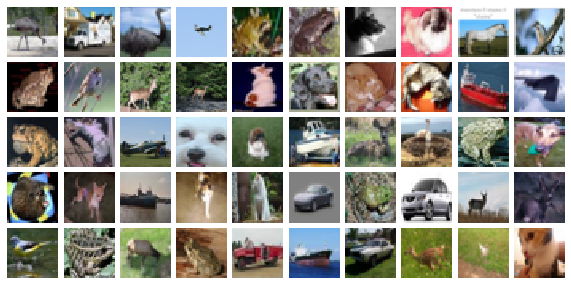

Noisy Input for encoder torch.float32


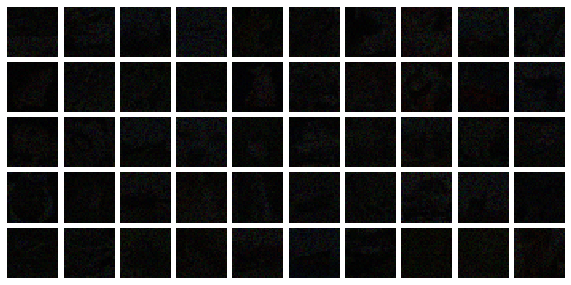

AutoEncoder Output torch.float32


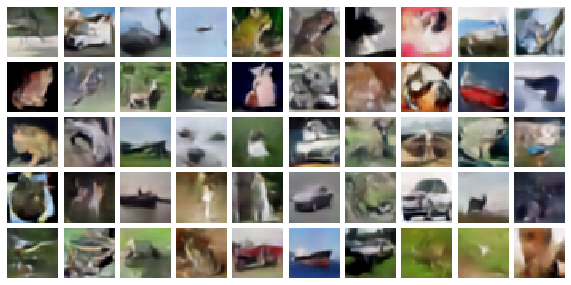

In [23]:
def visualise_img(tensor, num_cols=10):
    num_imgs = tensor.shape[0]
    num_rows = 1+ num_imgs // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(num_imgs):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i].transpose((1, 2, 0)))
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show() 

# check image with noise and denoised image\n# Better image if you train more or upgrade the model\n
for images,labels in test_loader:
    images_n = torch.mul(images+0.25, 0.1 * torch.rand(batch_size,3,32,32))
    if cuda:
        images=Variable(images).cuda()
        images_n=Variable(images_n).cuda()
    else:
        images = Variable(images)
        images_n = Variable(images_n)
    outputs=encoder(images_n)
    outputs=decoder(outputs)
    if cuda:
        outputs=Variable(outputs).cuda()
    else:
        outputs = Variable(outputs)
    break
  
  
print('Input', images.dtype)
visualise_img(images.detach().cpu().numpy())
print('Noisy Input for encoder', images_n.dtype)
visualise_img(images_n.detach().cpu().numpy())
print('AutoEncoder Output', outputs.dtype)
outputs = min_max_normalization(outputs,0,1)
visualise_img(outputs.detach().cpu().numpy())

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.input_hidden = nn.Linear(256*8*8,512)
        self.hidden_output = nn.Linear(512,10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x= x.view(-1,256*8*8) #reshaping the input
        x= self.relu(self.input_hidden(x))
        return self.hidden_output(x)

In [0]:
model = Net()
if cuda:
    model.cuda()

#Initialise loss function    
criterion = nn.CrossEntropyLoss()
if cuda:
  criterion = criterion.cuda()

#Initialise optimizer for model
optim=torch.optim.Adam(model.parameters(), lr=0.01)

In [26]:
'''
TRAIN THE MODEL
'''
num_epochs=4
iter = 0
for epoch in range(num_epochs):
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    #Add noise to data
    images_n = torch.mul(images+0.25, 0.1 * torch.rand(batch_size,3,32,32))
    
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    if cuda:
      images = Variable(images.cuda())
      images_n = Variable(images_n.cuda())
      labels = Variable(labels.cuda())
    else:
      images = Variable(images)
      images_n = Variable(images_n)
      labels = Variable(labels)
         
    # Clear gradients w.r.t. parameters
    optim.zero_grad()
         
    # Forward pass to get output/logits
    outputs = encoder(images_n)
    outputs = model(outputs)
        
    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, labels)
         
    # Getting gradients w.r.t. parameters
    loss.backward()
         
    # Updating parameters
    optim.step()
             
    iter += 1
         
    if iter % 1000 == 0:
      model.eval()
      # Calculate Accuracy
      total = 0
      correct = 0
      test_loss = 0.0
      # Iterate through test dataset
      for test_images, test_labels in test_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if cuda:
          test_images = Variable(images.cuda())
          test_images_n = Variable(images_n.cuda())
          test_labels = Variable(labels.cuda())
        else:
          test_images = Variable(images)
          test_images_n = Variable(images_n)
          test_labels = Variable(labels)
                 
        # Forward pass only to get logits/output
        test_outputs = encoder(images_n)
        test_outputs = model(test_outputs)

      test_loss = criterion(test_outputs, test_labels)
      # Print Loss
      print('Iteration: {}. Train_Loss: {}. Test_Loss: {}.'.format(iter, loss, test_loss))

Iteration: 1000. Train_Loss: 1.557013750076294. Test_Loss: 1.4772382974624634.
Iteration: 2000. Train_Loss: 1.860904574394226. Test_Loss: 1.7351303100585938.
Iteration: 3000. Train_Loss: 1.7089120149612427. Test_Loss: 1.5749813318252563.
Iteration: 4000. Train_Loss: 1.7488058805465698. Test_Loss: 1.5909931659698486.


In [27]:
torch.save(model.state_dict(), "model.th")
model.load_state_dict(torch.load("model.th"))
print(model)

Net(
  (input_hidden): Linear(in_features=16384, out_features=512, bias=True)
  (hidden_output): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)


ADAM OPTIMIZER

In [0]:
#Reference: http://ruder.io/optimizing-gradient-descent/index.html#adam


def Adam_opt(g_t, theta_t_prev, alpha = 0.001, eps = 1e-8, beta1 =0.9 , beta2 = 0.99):
  m_t_prev, v_t_prev = torch.zeros_like(g_t), torch.zeros_like(g_t)
  t=0
  
  while True:
    t += 1 
    m_t = beta1*m_t_prev + (1-beta1)*g_t
    v_t = beta2*v_t_prev + (1-beta2)*g_t**2
    m_hat = m_t/(1-beta1**t)
    v_hat = v_t/(1-beta2**t)
    theta_t = theta_t_prev - (alpha*m_hat)/(v_hat.sqrt().add_(eps))
    if (torch.norm(theta_t) == torch.norm(theta_t_prev)):
      break
    theta_t_prev = theta_t
  print(theta_t)

In [58]:
x = torch.randn(2, 2, requires_grad=False)
x

tensor([[-1.3823,  1.9587],
        [-1.5760,  0.3489]])

In [59]:
y = x**2 - 4*x + 4
y

tensor([[11.4401,  0.0017],
        [12.7880,  2.7261]])

In [60]:
w1 = torch.randn(2, 1, requires_grad=True) #Random weight (initially)
w1

tensor([[ 0.4352],
        [-0.0261]], requires_grad=True)

In [0]:
y_pred = x.mm(w1)
loss = (y_pred - y)**2
loss = loss.sum()  

In [62]:
loss

tensor(340.1578, grad_fn=<SumBackward0>)

In [0]:
#w1.grad.data.zero_()
loss.backward()
g_t = w1.grad

In [64]:
print(g_t)

tensor([[ 88.5239],
        [-61.7300]])


In [65]:
print('Updated Parameters: ')
Adam_opt(g_t, w1)

Updated Parameters: 
tensor([[-11585.0410],
        [ 11585.4404]], grad_fn=<ThSubBackward>)


Latent space of CAE for soccer ball

In [0]:
import tarfile
tf = tarfile.open("soccerball_data.tar.gz")
tf.extractall()
tf.close()

In [0]:
#latent space of CAE for soccer ball

#get the soccerball dataset
# Data augmentation and normalization for training
# Just normalization for validation

data_dir = 'soccerball_data'
data_transforms = {
    'train': transforms.Compose([
        
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: dsets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=10)       
                  for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [0]:
#train and evaluate soccerball_data
num_epochs=5
for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch, num_epochs - 1))
  print('-' * 10)
  
  running_loss = 0.0
  running_corrects = 0.0

  # Each epoch has a training and validation phase
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train(True)  # Set model to training mode
    else:
      model.eval()  # Set model to evaluate mode
      
    running_loss = 0.0 
    
    # Iterate over data.
    for data in dataloaders[phase]:
      # get the inputs
      inputs, labels = data
     
      inputs = np.reshape(inputs,(32,3,3,3))       
      # wrap them in Variable
      if cuda:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
      else:
        inputs, labels = Variable(inputs), Variable(labels)

      # zero the parameter gradients
      optim.zero_grad()

      # forward
      outputs = encoder(inputs)
      outputs = model(outputs)
      _, preds = torch.max(outputs.data, 1)
      loss = criterion(outputs, labels)

      # backward + optimize only if in training phase
      if phase == 'train':
        loss.backward()
        optim.step()

      # statistics
      running_loss += loss.data[0]

      epoch_loss = running_loss / dataset_sizes[phase]
      print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))